# 5DOF Cart-Pole System Model - Position

Theoretical mathematical model of the 5DOF cart-pole system in the coordinate system $ (x, y, z, \theta, \varphi) $ with wheels' angular velocity as free variables.

Dynamic model uses Euler-Lagrange equations.

Code prefixes:
- cs: coordinate system
- fn: function
- fv: free variable
- l: lagrangian/energy
- p: point

Code suffixes:
- d: derivative
- dd: second derivative
- jac: jacobian

## Classes

Utility classes to enhance the code's readability.

- StateXyz: State class for a point in the $ (x, y, z) $ Cartesian coordinates.
- StateGen: State class for a point in the $ (x, y, z, \theta, \varphi) $ generalized coordinates.
- Lagrangian: Lagrangian class for a Lagrangian or energy function.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

from IPython.display import display, Math, Latex
from qpsolvers import solve_qp
from sympy.utilities.codegen import codegen

In [2]:
class StateXyz:
    _map = {
        'x': (0, 'X'), 'y': (1, 'X'), 'z': (2, 'X'),
        'xd': (0, 'Xd'), 'yd': (1, 'Xd'), 'zd': (2, 'Xd'),
        'xdd': (0, 'Xdd'), 'ydd': (1, 'Xdd'), 'zdd': (2, 'Xdd')
    }

    def __init__(self, name, X=None, Xd=None, Xdd=None):
        self._name = name
        self.X = X
        self.Xd = Xd
        self.Xdd = Xdd
        self._X_norm = self._Xd_norm = self._Xdd_norm = None

    def __getattr__(self, key):
        if key in self._map:
            idx, attr = self._map[key]
            val = getattr(self, attr)
            if val is not None:
                return val[idx]
            raise AttributeError(f"{attr} is None for key '{key}'")
        raise AttributeError(f"{key} not found")

    def __setattr__(self, key, value):
        if key in {'_name', 'X', 'Xd', 'Xdd', '_X_norm', '_Xd_norm', '_Xdd_norm'}:
            super().__setattr__(key, value)
        elif key in self._map:
            idx, attr = self._map[key]
            array = getattr(self, attr)
            if array is not None:
                array[idx] = value
            else:
                raise AttributeError(f"{attr} is None, cannot assign '{key}'")
        else:
            super().__setattr__(key, value)

    @property
    def X_norm(self):
        if self._X_norm is None and self.X is not None:
            return sp.sqrt(self.X.dot(self.X))
        return self._X_norm

    @X_norm.setter
    def X_norm(self, value):
        self._X_norm = value

    @property
    def Xd_norm(self):
        if self._Xd_norm is None and self.Xd is not None:
            return sp.sqrt(self.Xd.dot(self.Xd))
        return self._Xd_norm

    @Xd_norm.setter
    def Xd_norm(self, value):
        self._Xd_norm = value

    @property
    def Xdd_norm(self):
        if self._Xdd_norm is None and self.Xdd is not None:
            return sp.sqrt(self.Xdd.dot(self.Xdd))
        return self._Xdd_norm

    @Xdd_norm.setter
    def Xdd_norm(self, value):
        self._Xdd_norm = value

    def diff(self, wrt):
        if self.X is not None:
            self.Xd = self.X.diff(wrt)

    def diff2(self, wrt):
        if self.Xd is not None:
            self.Xdd = self.Xd.diff(wrt)

In [3]:
class StateGen:
    _map = {
        'x': (0, 'Q'), 'y': (1, 'Q'), 'z': (2, 'Q'), 'theta': (3, 'Q'), 'phi': (4, 'Q'),
        'xd': (0, 'Qd'), 'yd': (1, 'Qd'), 'zd': (2, 'Qd'), 'thetad': (3, 'Qd'), 'phid': (4, 'Qd'),
        'xdd': (0, 'Qdd'), 'ydd': (1, 'Qdd'), 'zdd': (2, 'Qdd'), 'thetadd': (3, 'Qdd'), 'phidd': (4, 'Qdd')
    }

    def __init__(self, name, Q=None, Qd=None, Qdd=None):
        self._name = name

        if Q is None:
            self.Q = sp.Matrix([
                sp.Symbol(r'x_{' + name + '}'),
                sp.Symbol(r'y_{' + name + '}'),
                sp.Symbol(r'z_{' + name + '}'),
                sp.Symbol(r'\theta_{' + name + '}'),
                sp.Symbol(r'\phi_{' + name + '}')
            ])
        elif isinstance(Q, sp.Matrix):
            self.Q = Q
        else:
            raise TypeError(f"Q must be a Matrix, not {type(Q)}")

        if Qd is None:
            self.Qd = sp.Matrix([
                sp.Symbol(r'\dot{x}_{' + name + '}'),
                sp.Symbol(r'\dot{y}_{' + name + '}'),
                sp.Symbol(r'\dot{z}_{' + name + '}'),
                sp.Symbol(r'\dot{\theta}_{' + name + '}'),
                sp.Symbol(r'\dot{\phi}_{' + name + '}')
            ])
        elif isinstance(Qd, sp.Matrix):
            self.Qd = Qd
        else:
            raise TypeError(f"Qd must be a Matrix, not {type(Qd)}")

        if Qdd is None:
            self.Qdd = sp.Matrix([
                sp.Symbol(r'\ddot{x}_{' + name + '}'),
                sp.Symbol(r'\ddot{y}_{' + name + '}'),
                sp.Symbol(r'\ddot{z}_{' + name + '}'),
                sp.Symbol(r'\ddot{\theta}_{' + name + '}'),
                sp.Symbol(r'\ddot{\phi}_{' + name + '}')
            ])
        elif isinstance(Qdd, sp.Matrix):
            self.Qdd = Qdd
        else:
            raise TypeError(f"Qdd must be a Matrix, not {type(Qdd)}")

        self._Q_norm = self._Qd_norm = self._Qdd_norm = None

    def __getattr__(self, key):
        if key in self._map:
            idx, attr = self._map[key]
            val = getattr(self, attr)
            if val is not None:
                return val[idx]
            raise AttributeError(f"{attr} is None for key '{key}'")
        raise AttributeError(f"{key} not found")

    def __setattr__(self, key, value):
        if key in {'_name', 'Q', 'Qd', 'Qdd', '_Q_norm', '_Qd_norm', '_Qdd_norm'}:
            super().__setattr__(key, value)
        elif key in self._map:
            idx, attr = self._map[key]
            array = getattr(self, attr)
            if array is not None:
                array[idx] = value
            else:
                raise AttributeError(f"{attr} is None, cannot assign '{key}'")
        else:
            super().__setattr__(key, value)

    @property
    def Q_norm(self):
        if self._Q_norm is None and self.Q is not None:
            return sp.sqrt(self.Q.dot(self.Q))
        return self._Q_norm

    @Q_norm.setter
    def Q_norm(self, value):
        self._Q_norm = value

    @property
    def Qd_norm(self):
        if self._Qd_norm is None and self.Qd is not None:
            return sp.sqrt(self.Qd.dot(self.Qd))
        return self._Qd_norm

    @Qd_norm.setter
    def Qd_norm(self, value):
        self._Qd_norm = value

    @property
    def Qdd_norm(self):
        if self._Qdd_norm is None and self.Qdd is not None:
            return sp.sqrt(self.Qdd.dot(self.Qdd))
        return self._Qdd_norm

    @Qdd_norm.setter
    def Qdd_norm(self, value):
        self._Qdd_norm = value

    def diff(self, wrt):
        if self.Q is not None:
            self.Qd = self.Q.diff(wrt)
        return self.Qd

    def diff2(self, wrt):
        if self.Qd is not None:
            self.Qdd = self.Qd.diff(wrt)
        return self.Qdd

In [4]:
class Lagrangian:
    def __init__(self, name, t, state_gen=None):
        self._name = name
        self._t = t
        self._cs = state_gen

        self._L = None
        self._L_dq = None
        self._L_dqd = None
        self._L_dqd_dt = None

    @property
    def L(self):
        return self._L

    @L.setter
    def L(self, value):
        self._L = value
        self._L_dq = sp.simplify(self._L.diff(self._cs.Q))
        self._L_dqd = sp.simplify(self._L.diff(self._cs.Qd))
        self._L_dqd_dt = sp.simplify(self._L_dqd.diff(self._t))

    @property
    def L_dq(self):
        return self._L_dq

    @property
    def L_dqd(self):
        return self._L_dqd

    @property
    def L_dqd_dt(self):
        return self._L_dqd_dt

    def __add__(self, other):
        if isinstance(other, Lagrangian):
            tmp = Lagrangian(f"{self._name}+{other._name}", self._t, self._cs)
            tmp.L = self.L + other.L
            return tmp
        else:
            raise NotImplementedError()

    def __sub__(self, other):
        if isinstance(other, Lagrangian):
            tmp = Lagrangian(f"{self._name}+{other._name}", self._t, self._cs)
            tmp.L = self.L - other.L
            return tmp
        else:
            raise NotImplementedError()

 ## Model

The mathematical model of the cart-pole system assumes an axle that connects the two wheels and the pole, with the origin $ X_o $ located at the intersection of the axle and the pole, center of mass at $ X_c $, and an angled ground plane.

The generalized coordinate system taken is $ (x, y, z, \theta, \varphi) $, where $x$, $y$, $z$ are the Cartesian coordinates, and $\theta$, $\varphi$ are the angles of rotation of the cart with respect to the vertical direction and of the cart with respect to the $x$-$y$ plane, respectively.
The coordinate system is shown below.

<img src="../assets/cart_coordinates.png" alt="Cart coordinates" width="300"/>

The geometric parameters of the cart are shown below.

<img src="../assets/cart_geometry.png" alt="Cart geometry" width="800"/>

In [5]:
dof = 5

t = sp.symbols(r't')

cs_q = StateGen('q')
cs_q.x = sp.Function(r'x')(t)
cs_q.y = sp.Function(r'y')(t)
cs_q.z = sp.Function(r'z')(t)
cs_q.theta = sp.Function(r'\theta')(t)
cs_q.phi = sp.Function(r'\varphi')(t)
cs_q.diff(t)
cs_q.diff2(t)

args_cs = [t, cs_q.x, cs_q.xd, cs_q.y, cs_q.yd, cs_q.z, cs_q.zd, cs_q.theta, cs_q.thetad, cs_q.phi, cs_q.phid]

In [6]:
fv_omega_l = sp.symbols(r'\omega_l', constant=True)  # angular velocity of the cart's left wheel, free variable
fv_omega_r = sp.symbols(r'\omega_r', constant=True)  # angular velocity of the cart's right wheel, free variable

args_fv = [fv_omega_l, fv_omega_r]

In [7]:
args = args_cs + args_fv

In [8]:
# Utils
sp_half = sp.Rational(1, 2)
plane_dir = sp.Matrix([sp.cos(cs_q.phi), sp.sin(cs_q.phi), 0])

In [9]:
# Constants
agx, agy, xcm, ycm, zcm, hb, hr, eb, ew, dw = sp.symbols(r'a_{gx}, a_{gy}, x_{cm}, y_{cm}, z_{cm}, h_b, h_r, e_b, e_w, d_w', constant=True)
m, Ir, Iz, Iw, ba, bw, bd, ct, rho, g = sp.symbols(r'm, I_r, I_z, I_w, b_a, b_w, b_d, c_{\theta}, \rho, g', constant=True)

params = [
    agx,  # factor in the x coordinate for the ground plane
    agy,  # factor in the y coordinate for the ground plane
    xcm,  # x coordinate of the body's mass center
    ycm,  # y coordinate of the body's mass center
    zcm,  # z coordinate of the body's mass center
    hb,  # height of body
    eb,  # body width
    dw,  # wheel diameter
    m,  # mass in kg
    Ir,  # moment of inertia
    Iz,  # moment of inertia
    Iw,  # moment of inertia
    ba,  # damping coefficient
    bw,  # damping coefficient
    bd,  # drag coefficient
    ct,  # theta_dot correction factor, ideally sp.tanh(theta_dot - (omega_l + omega_r))
    rho,  # air density
    g,  # gravity in m/s^2
]

### Kinematic model

#### Kinematics for the body's left wheel

The kinematics for the body's left wheel are given by the effects of the wheel rotation and the angle of rotation of the cart with respect to the vertical direction

$$ \dot{q}_{w,l} = \frac{ d_w }{ 2 } \left( \omega_l + \frac{d}{dt} \theta \right) \cdot \begin{bmatrix} \cos(\varphi) \\ \sin(\varphi) \\ 0 \end{bmatrix} $$

In [10]:
p_whl = StateXyz('wh,l')

In [11]:
p_whl.Xd = ((fv_omega_l + cs_q.thetad) * dw / 2) * plane_dir
p_whl.zd = cs_q.zd

# Output
display(p_whl.Xd)

Matrix([
[d_w*(\omega_l + Derivative(\theta(t), t))*cos(\varphi(t))/2],
[d_w*(\omega_l + Derivative(\theta(t), t))*sin(\varphi(t))/2],
[                                        Derivative(z(t), t)]])

#### Kinematics for the body's right wheel

The kinematics for the body's right wheel are given by the effects of the wheel rotation and the angle of rotation of the cart with respect to the vertical direction

$$ \dot{q}_{w,r} = \frac{ d_w }{ 2 } \left( \omega_r + \frac{d}{dt} \theta \right) \cdot \begin{bmatrix} \cos(\varphi) \\ \sin(\varphi) \\ 0 \end{bmatrix} $$

In [12]:
p_whr = StateXyz('wh,r')

In [13]:
p_whr.Xd = ((fv_omega_r + cs_q.thetad) * dw / 2) * plane_dir
p_whr.zd = cs_q.zd

# Output
display(p_whr.Xd)

Matrix([
[d_w*(\omega_r + Derivative(\theta(t), t))*cos(\varphi(t))/2],
[d_w*(\omega_r + Derivative(\theta(t), t))*sin(\varphi(t))/2],
[                                        Derivative(z(t), t)]])

#### Movement due to the wheels rotation

The movement due to the wheels is separated by its contributions to the cart's normal velocity in the $x$-$y$ plane

$$ v = \frac{ \dot{q}_{w,l} + \dot{q}_{w,r} }{ 2 } $$

and to the cart's rotation in the $x$-$y$ plane

$$ \dot{\varphi} = \frac{ \dot{q}_{w,l} - \dot{q}_{w,r} }{ 2 e_b } $$

In [14]:
fv_speed = sp_half * dw * (fv_omega_l + fv_omega_r) / 2
fv_rot = (fv_omega_l - fv_omega_r) / (2 * eb)

#### Kinematics for the body's origin

The kinematics for the body's origin are modeled with position

$$ X_o = \begin{bmatrix} x \\ y \\ z \end{bmatrix} $$

and velocity

$$ \dot{X}_o = \begin{bmatrix} \dot{x} \\ \dot{y} \\ \dot{z} \end{bmatrix} + v \cdot \begin{bmatrix} \cos(\varphi) \\ \sin(\varphi) \\ 0 \end{bmatrix} $$

where $ v $ is the normal velocity of the body in the x-y plane given by the left and right wheels motion.

In [15]:
p_origin = StateXyz('o')

In [16]:
p_origin.X = sp.Matrix([
    cs_q.x,
    cs_q.y,
    cs_q.z,
])

# Lambdify
fn_Xo = sp.lambdify(args + params, p_origin.X)

# Output
display(p_origin.X)

Matrix([
[x(t)],
[y(t)],
[z(t)]])

In [17]:
p_origin.Xd = p_origin.X.diff(t) + fv_speed * plane_dir

# Lambdify
fn_Xo_dot = sp.lambdify(args + params, p_origin.Xd)

# Output
display(p_origin.Xd)

Matrix([
[d_w*(\omega_l + \omega_r)*cos(\varphi(t))/4 + Derivative(x(t), t)],
[d_w*(\omega_l + \omega_r)*sin(\varphi(t))/4 + Derivative(y(t), t)],
[                                              Derivative(z(t), t)]])

#### Kinematics for the body's center of mass

The kinematics for the body's center of mass are modeled as the superposition of the relative motion between the center of mass and the origin, and the kinematics of the body's origin.

$$ X_c = X_o + X_{c,o} $$

where $ X_{c,o} $ is given by the geometric position of the mass center $ [ x_{cm} \>\> y_{cm} \>\> z_{cm}] $ relative to the origin rotated by the angles $ (\theta, \varphi) $ with respect to their axis.

In [18]:
p_center_origin = StateXyz('c,o')
p_center = StateXyz('c')

In [19]:
p_center_origin.X = (sp.rot_givens(1, 0, cs_q.phi) * (sp.rot_givens(0, 2, cs_q.theta)) * sp.Matrix([xcm, ycm, zcm]))

# Lambdify
fn_Xco = sp.lambdify(args + params, p_center_origin.X)

# Output
display(p_center_origin.X)

Matrix([
[x_{cm}*cos(\theta(t))*cos(\varphi(t)) - y_{cm}*sin(\varphi(t)) + z_{cm}*sin(\theta(t))*cos(\varphi(t))],
[x_{cm}*sin(\varphi(t))*cos(\theta(t)) + y_{cm}*cos(\varphi(t)) + z_{cm}*sin(\theta(t))*sin(\varphi(t))],
[                                                        -x_{cm}*sin(\theta(t)) + z_{cm}*cos(\theta(t))]])

In [20]:
p_center_origin.diff(t)

# Lambdify
fn_Xco_dot = sp.lambdify(args + params, p_center_origin.Xd)

# Output
display(p_center_origin.Xd)

Matrix([
[-x_{cm}*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) - x_{cm}*sin(\varphi(t))*cos(\theta(t))*Derivative(\varphi(t), t) - y_{cm}*cos(\varphi(t))*Derivative(\varphi(t), t) - z_{cm}*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), t) + z_{cm}*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)],
[-x_{cm}*sin(\theta(t))*sin(\varphi(t))*Derivative(\theta(t), t) + x_{cm}*cos(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) - y_{cm}*sin(\varphi(t))*Derivative(\varphi(t), t) + z_{cm}*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) + z_{cm}*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)],
[                                                                                                                                                                                                                       -x_{cm}*cos(\theta(t))*Derivative(\theta(t), t) - z_{cm}*sin(\theta(t))*Derivative(\theta(t), t)]])

In [21]:
p_center.X = p_origin.X + p_center_origin.X

# Lambdify
fn_Xc = sp.lambdify(args + params, p_center.X)

# Output
display(p_center.X)

Matrix([
[x_{cm}*cos(\theta(t))*cos(\varphi(t)) - y_{cm}*sin(\varphi(t)) + z_{cm}*sin(\theta(t))*cos(\varphi(t)) + x(t)],
[x_{cm}*sin(\varphi(t))*cos(\theta(t)) + y_{cm}*cos(\varphi(t)) + z_{cm}*sin(\theta(t))*sin(\varphi(t)) + y(t)],
[                                                        -x_{cm}*sin(\theta(t)) + z_{cm}*cos(\theta(t)) + z(t)]])

In [22]:
p_center.Xd = p_origin.Xd + p_center_origin.Xd

# Lambdify
fn_Xc_dot = sp.lambdify(args + params, p_center.Xd)

# Output
display(p_center.Xd)

Matrix([
[d_w*(\omega_l + \omega_r)*cos(\varphi(t))/4 - x_{cm}*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) - x_{cm}*sin(\varphi(t))*cos(\theta(t))*Derivative(\varphi(t), t) - y_{cm}*cos(\varphi(t))*Derivative(\varphi(t), t) - z_{cm}*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), t) + z_{cm}*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + Derivative(x(t), t)],
[d_w*(\omega_l + \omega_r)*sin(\varphi(t))/4 - x_{cm}*sin(\theta(t))*sin(\varphi(t))*Derivative(\theta(t), t) + x_{cm}*cos(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) - y_{cm}*sin(\varphi(t))*Derivative(\varphi(t), t) + z_{cm}*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) + z_{cm}*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + Derivative(y(t), t)],
[                                                                                                                                                                                                                                  

In [23]:
# Output
display(p_center.Xd_norm)

sqrt((-x_{cm}*cos(\theta(t))*Derivative(\theta(t), t) - z_{cm}*sin(\theta(t))*Derivative(\theta(t), t) + Derivative(z(t), t))**2 + (d_w*(\omega_l + \omega_r)*sin(\varphi(t))/4 - x_{cm}*sin(\theta(t))*sin(\varphi(t))*Derivative(\theta(t), t) + x_{cm}*cos(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) - y_{cm}*sin(\varphi(t))*Derivative(\varphi(t), t) + z_{cm}*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) + z_{cm}*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + Derivative(y(t), t))**2 + (d_w*(\omega_l + \omega_r)*cos(\varphi(t))/4 - x_{cm}*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) - x_{cm}*sin(\varphi(t))*cos(\theta(t))*Derivative(\varphi(t), t) - y_{cm}*cos(\varphi(t))*Derivative(\varphi(t), t) - z_{cm}*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), t) + z_{cm}*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + Derivative(x(t), t))**2)

### Dynamic model

#### Kinect energy of the body

The kinect energy $ T $ in the cart-pole system is given by the sum of the kinect energies from:
- translational velocity of the body,
- angular velocity of the body due to $ \frac{d}{dt} \theta $,
- angular velocity of the body in the x-y plane due to $ \frac{d}{dt} \varphi $, and
- angular velocity of the wheels.

Assuming the hypothesis $ \frac{ 2 || \dot{q}_c || }{ dw } \gg \dot{\theta} $, then the kinetic energy from $ \omega_l $ and $ \omega_r $ can be simplified by removing the effect of $ \dot{\theta} $.
This hypothesis is valid when $ \dot{\theta} \approx 0 $ or $ \dot{\theta} \approx \omega_l + \omega_r $.

We assume that $ \dot{\theta} \ll \omega_l + \omega_r $ iff $ \dot{\theta} \approx 0 $.
Therefore, we can add a correction term only for the case $ \dot{\theta} \gg \omega_l + \omega_r $ by adding $ c_{\theta} \cdot 2 \dot{\theta} ^2 $.

In [24]:
l_kinect = Lagrangian('T', t, cs_q)

l_kinect.L = (
        sp_half * m * p_center.Xd_norm ** 2
        + sp_half * (Iz + m * ((xcm * sp.cos(cs_q.theta)) ** 2 + ycm ** 2 + (zcm * sp.sin(cs_q.theta)) ** 2)) * cs_q.phid ** 2
        + sp_half * Ir * cs_q.thetad ** 2
        + sp_half * Iw * ((fv_omega_l + cs_q.thetad) ** 2 + (fv_omega_r + cs_q.thetad) ** 2 + ct * 2 * cs_q.thetad ** 2)
)

# Lambdify
fn_l_kinect = sp.lambdify(args + params, l_kinect.L)

# Output
l_kinect.L = sp.simplify(l_kinect.L)
display(l_kinect.L)

I_r*Derivative(\theta(t), t)**2/2 + I_w*(2*c_{\theta}*Derivative(\theta(t), t)**2 + (\omega_l + Derivative(\theta(t), t))**2 + (\omega_r + Derivative(\theta(t), t))**2)/2 + m*(16*(x_{cm}*cos(\theta(t))*Derivative(\theta(t), t) + z_{cm}*sin(\theta(t))*Derivative(\theta(t), t) - Derivative(z(t), t))**2 + (d_w*(\omega_l + \omega_r)*sin(\varphi(t)) - 4*x_{cm}*sin(\theta(t))*sin(\varphi(t))*Derivative(\theta(t), t) + 4*x_{cm}*cos(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) - 4*y_{cm}*sin(\varphi(t))*Derivative(\varphi(t), t) + 4*z_{cm}*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) + 4*z_{cm}*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + 4*Derivative(y(t), t))**2 + (-d_w*(\omega_l + \omega_r)*cos(\varphi(t)) + 4*x_{cm}*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + 4*x_{cm}*sin(\varphi(t))*cos(\theta(t))*Derivative(\varphi(t), t) + 4*y_{cm}*cos(\varphi(t))*Derivative(\varphi(t), t) + 4*z_{cm}*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), t) 

#### Potential energy of the body

The potential energy $ V $ in the cart-pole system is determined only by the gravitational potential energy.

In [25]:
l_potential = Lagrangian('V', t, cs_q)

l_potential.L = m * g * p_center.X.dot(sp.Matrix([0, 0, 1]))

# Lambdify
fn_l_potential = sp.lambdify(args + params, l_potential.L)

# Output
l_potential.L = sp.simplify(l_potential.L)
display(l_potential.L)

g*m*(-x_{cm}*sin(\theta(t)) + z_{cm}*cos(\theta(t)) + z(t))

#### Dissipation energy of the body

To handle the effects of velocity-proportional frictional forces in the axle and ground-wheel contact, the $ D_a $ and $ D_w $ Rayleigh dissipation functions are used, respectively.

$$ D_a = \frac{1}{2} b_a \left( \omega_l^2 + \omega_r^2 \right) $$

$$ D_w = \frac{1}{2} b_w \left( || \dot{q}_{w,l} ||^2 + || \dot{q}_{w,r} ||^2 \right) $$

The total dissipation from velocity-proportional frictional forces is given by

$$ D = D_a + D_w $$

In [26]:
l_diss_axle = Lagrangian('D,a', t, cs_q)

l_diss_axle.L = sp_half * ba * (fv_omega_l ** 2 + fv_omega_r ** 2)

# Output
l_diss_axle.L = sp.simplify(l_diss_axle.L)
display(l_diss_axle.L)

b_a*(\omega_l**2 + \omega_r**2)/2

In [27]:
l_diss_wheels = Lagrangian('D,w', t, cs_q)

l_diss_wheels.L = sp_half * bw * (p_whl.Xd_norm ** 2 + p_whr.Xd_norm ** 2)

# Output
l_diss_wheels.L = sp.simplify(l_diss_wheels.L)
display(l_diss_wheels.L)

b_w*(\omega_l**2*d_w**2 + 2*\omega_l*d_w**2*Derivative(\theta(t), t) + \omega_r**2*d_w**2 + 2*\omega_r*d_w**2*Derivative(\theta(t), t) + 2*d_w**2*Derivative(\theta(t), t)**2 + 8*Derivative(z(t), t)**2)/8

In [28]:
l_diss = Lagrangian('D', t, cs_q)

l_diss = l_diss_axle + l_diss_wheels

# Output
l_diss.L = sp.simplify(l_diss.L)
display(l_diss.L)

b_a*(\omega_l**2 + \omega_r**2)/2 + b_w*(\omega_l**2*d_w**2 + 2*\omega_l*d_w**2*Derivative(\theta(t), t) + \omega_r**2*d_w**2 + 2*\omega_r*d_w**2*Derivative(\theta(t), t) + 2*d_w**2*Derivative(\theta(t), t)**2 + 8*Derivative(z(t), t)**2)/8

#### External forces

The external force from the air drag $ E_d $ that executes the work $ W_d $ is taken as the only external force in the cart-pole system, with total work done $ W $.

Assuming the hypothesis of the air relative velocity being small, we can take the first-order approximation $ x^2 \approx x $ to avoid some non-linear terms and expensive square root computations.

In [29]:
Xair_dot = p_center.Xd + zcm * cs_q.thetad * sp.Matrix([sp.sin(cs_q.theta) * sp.cos(cs_q.phi), sp.sin(cs_q.theta) * sp.sin(cs_q.phi), sp.cos(cs_q.theta)])
Ed = - sp_half * rho * bd * Xair_dot

# Output
display(Ed)

Matrix([
[-\rho*b_d*(d_w*(\omega_l + \omega_r)*cos(\varphi(t))/4 - x_{cm}*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) - x_{cm}*sin(\varphi(t))*cos(\theta(t))*Derivative(\varphi(t), t) - y_{cm}*cos(\varphi(t))*Derivative(\varphi(t), t) - z_{cm}*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), t) + z_{cm}*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + z_{cm}*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + Derivative(x(t), t))/2],
[-\rho*b_d*(d_w*(\omega_l + \omega_r)*sin(\varphi(t))/4 - x_{cm}*sin(\theta(t))*sin(\varphi(t))*Derivative(\theta(t), t) + x_{cm}*cos(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) - y_{cm}*sin(\varphi(t))*Derivative(\varphi(t), t) + z_{cm}*sin(\theta(t))*sin(\varphi(t))*Derivative(\theta(t), t) + z_{cm}*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) + z_{cm}*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + Derivative(y(t), t))/2],
[                                                                    

In [30]:
Wd_dq = sp.Matrix([Ed.dot(p_center.X.diff(qi)) for qi in cs_q.Q])

# Output
Wd_dq = sp.simplify(Wd_dq)
display(Wd_dq)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   -\rho*b_d*(\omega_l*d_w*cos(\varphi(t)) + \omega_r*d_w*cos(\varphi(t)) - 4*x_{cm}*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) - 4*x_{cm}*sin(\varphi(t))*cos(\theta(t))*Derivative(\varphi(t), t) - 4*y_{cm}*cos(\varphi(t))*Derivative(\varphi(t), t) + 4*sqrt(2)*z_{cm}*sin(\theta(t) + pi/4)*cos(\varphi(t))*Derivative(\theta(t), t) - 4*z_{cm}*sin(\theta(t))*sin(\varphi(

In [31]:
W_dq = Wd_dq

# Output
W_dq = sp.simplify(W_dq)
display(W_dq)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     -\rho*b_d*(\omega_l*d_w*cos(\varphi(t)) + \omega_r*d_w*cos(\varphi(t)) - 4*x_{cm}*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) - 4*x_{cm}*sin(\varphi(t))*cos(\theta(t))*Derivative(\varphi(t), t) - 4*y_{cm}*cos(\varphi(t))*Derivative(\varphi(t), t) + 4*sqrt(2)*z_{cm}*sin(\theta(t) + pi/4)*cos(\varphi(t))*Derivative(\theta(t), t) - 4*z_{cm}*sin(\theta(t))*sin(\varph

#### Constraints

To apply physical constraints, we need to define the constraints in the form of a function of the state variables. The constraints can be holonomic $ c = 0 $ or non-holonomic $ c \ge 0 $, which are solved using Lagrange multipliers and complementary slack variables, respectively.

##### Holomonic constraints

The cart-pole system is assumed to move without slip on the ground-wheel contact. However, this constraint is already assumed and applied in the kinematic model, and therefore does not need to be explicitly solved.

##### Non-holomonic constraints

To apply the ground contact constraint, the ground is taken as a plane at $ z_g = a_{g,x} x + a_{g,y} y - d_w / 2 $.

We assume that if the ground constraints at the wheel and at the tip are satisfied, then the ground constraints at any point of the cart-pole system are also satisfied.

$$ c_{g,wheel} = z_o - \frac{ d_w }{ 2 } \ge z_g $$

$$ c_{g,tip} = z_o + h_b cos(\theta) \ge z_g $$

In [32]:
p_ground = StateXyz('o')

p_ground.X = sp.Matrix([
    p_origin.x,
    p_origin.y,
    agx * p_origin.x + agy * p_origin.y - dw / 2,
])

# Lambdify
fn_ground = sp.lambdify(args + params, p_ground.X)

# Output
display(p_ground.X)

Matrix([
[                             x(t)],
[                             y(t)],
[a_{gx}*x(t) + a_{gy}*y(t) - d_w/2]])

In [33]:
cons_gwheel = sp.Symbol(r'cons_{g,wheel}')
cons_gwheel = p_origin.z - dw / 2 - p_ground.z

# Output
cons_gwheel

-a_{gx}*x(t) - a_{gy}*y(t) + z(t)

In [34]:
cons_gtip = sp.Symbol(r'cons_{g,tip}')
cons_gtip = hb * sp.cos(cs_q.theta) - p_ground.z

# Output
cons_gtip

-a_{gx}*x(t) - a_{gy}*y(t) + d_w/2 + h_b*cos(\theta(t))

In [35]:
Cons = sp.Matrix([cons_gwheel, cons_gtip])
ncons = len(Cons)

# Lambdify
fn_Cons = sp.lambdify(args + params, Cons)

# Output
Cons

Matrix([
[                      -a_{gx}*x(t) - a_{gy}*y(t) + z(t)],
[-a_{gx}*x(t) - a_{gy}*y(t) + d_w/2 + h_b*cos(\theta(t))]])

In [36]:
Cons_gradq = Cons.jacobian(cs_q.Q)

# Lambdify
fn_Cons_gradq = sp.lambdify(args + params, Cons_gradq)

# Output
Cons_gradq

Matrix([
[-a_{gx}, -a_{gy}, 1,                   0, 0],
[-a_{gx}, -a_{gy}, 0, -h_b*sin(\theta(t)), 0]])

In [37]:
Cons_gradqd = Cons.jacobian(cs_q.Qd)

# Lambdify
fn_Cons_gradqd = sp.lambdify(args + params, Cons_gradqd)

# Output
Cons_gradqd

Matrix([
[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0]])

#### Lagrangian

The lagrangian is defined as

$$ L = T - V $$

where $ T $ is the kinetic energy and $ V $ is the potential energy.

In [38]:
l_lagrangian = Lagrangian('L', t, cs_q)

l_lagrangian = l_kinect - l_potential

# Output
l_lagrangian.L = sp.simplify(l_lagrangian.L)
display(l_lagrangian.L)

I_r*Derivative(\theta(t), t)**2/2 + I_w*(2*c_{\theta}*Derivative(\theta(t), t)**2 + (\omega_l + Derivative(\theta(t), t))**2 + (\omega_r + Derivative(\theta(t), t))**2)/2 - g*m*(-x_{cm}*sin(\theta(t)) + z_{cm}*cos(\theta(t)) + z(t)) + m*(16*(x_{cm}*cos(\theta(t))*Derivative(\theta(t), t) + z_{cm}*sin(\theta(t))*Derivative(\theta(t), t) - Derivative(z(t), t))**2 + (d_w*(\omega_l + \omega_r)*sin(\varphi(t)) - 4*x_{cm}*sin(\theta(t))*sin(\varphi(t))*Derivative(\theta(t), t) + 4*x_{cm}*cos(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) - 4*y_{cm}*sin(\varphi(t))*Derivative(\varphi(t), t) + 4*z_{cm}*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) + 4*z_{cm}*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + 4*Derivative(y(t), t))**2 + (-d_w*(\omega_l + \omega_r)*cos(\varphi(t)) + 4*x_{cm}*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + 4*x_{cm}*sin(\varphi(t))*cos(\theta(t))*Derivative(\varphi(t), t) + 4*y_{cm}*cos(\varphi(t))*Derivative(\varphi(t), t) + 4*z_

### Compiled model

The dynamic model is given by the Euler-Lagrange in the form of

$$ \frac{d}{dt} \left( \frac{\partial L}{\partial \dot{q}} \right) - \frac{\partial L}{\partial q} + \frac{\partial D}{\partial \dot{q}} = \frac{\partial W}{\partial q} $$

where $ L $ is the lagrangian, $ D $ is the dissipation energies, and $ W $ is the work done by external forces.

The model's equation is then factorized as

$$ M(q) \ddot{q} + H(q, \dot{q}) = 0 $$

and as

$$ M_{ii}(q) \ddot{q} + B_{i2}(q) \dot{q}^2 + B_{ij}(q, \dot{q}) \dot{q} + B_{i}(q) \dot{q} + C(q) = 0 $$

In [39]:
model = l_lagrangian.L_dqd_dt - l_lagrangian.L_dq + l_diss.L_dqd - W_dq

# Output
model = sp.simplify(model)
display(model)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [40]:
# Separate model into `M * Qi_ddot + H = Mii * Qi_ddot + Bi2 * Qi_dot**2 + Bij * Qi_dot * Qj_dot + Bi * Qi_dot + C` form
dim = len(model)
model_expand = sp.zeros(dim, 1)
for i, eq in enumerate(model):
    model_expand[i] = sp.expand(eq)

Mii = sp.zeros(dim, dim)
Bi2 = sp.zeros(dim, dim)
Bij = sp.zeros(dim, dim)
Bi = sp.zeros(dim, dim)
C = sp.zeros(dim, 1)
U = sp.zeros(dim, 1)

# Collect coefficients for each second derivative term
for i, eq in enumerate(model_expand):
    subs_list = []

    # Isolate second-order and squared first-order derivatives
    for j, qi_dot in enumerate(cs_q.Qd):
        Mii[i, j] = eq.coeff(cs_q.Qdd[j], 1)
        subs_list += [(cs_q.Qdd[j], 0)]

        Bi2[i, j] = eq.coeff(qi_dot, 2)
        subs_list += [(qi_dot ** 2, 0)]

    terms = sp.Add.make_args(eq)
    for term in terms:
        # Isolate second-order distinct derivatives
        all_dot = [term.has(d) for d in cs_q.Qd]
        idx_dot = [i for i in range(len(all_dot)) if all_dot[i] == True]
        qi_dot = [d for d in all_dot if d == True]
        if len(idx_dot) == 2:
            for j in idx_dot:
                Bij[i, j] += term.coeff(cs_q.Qd[j], 1) / len(idx_dot)
                subs_list += [(term.coeff(cs_q.Qd[j], 1), 0)]

        # Isolate first-order linear derivatives
        for j, qi_dot in enumerate(cs_q.Qd):
            if term.count(qi_dot) == 1:
                other_derivs = [x for x in cs_q.Qd if x != qi_dot]
                if not any(term.has(od) for od in other_derivs):
                    Bi[i, j] += term.coeff(qi_dot, 1)
                    subs_list += [(term.coeff(qi_dot, 1), 0)]

        # Isolate zero-order derivatives
        if (sum(term.count(qi_ddot) for qi_ddot in cs_q.Qdd) == 0) and (sum(term.count(qi_dot) for qi_dot in cs_q.Qd) == 0):
            C[i] += term
            subs_list += [(term, 0)]

    model_expand[i] = eq.subs(subs_list)
    model_expand[i] = sp.expand(model_expand[i])

H = Bi2 * sp.Matrix([qi_dot ** 2 for qi_dot in cs_q.Qd]) + Bij * cs_q.Qd + Bi * cs_q.Qd + C + U
H = sp.simplify(H)

# Lambdify
fn_M = sp.lambdify(args + params, Mii)
fn_H = sp.lambdify(args + params, H)
# U_fn = sp.lambdify(args + params, U)  # See [Solver](#solver).

# Output
Mii = sp.simplify(Mii)
Bi2 = sp.simplify(Bi2)
Bij = sp.simplify(Bij)
Bi = sp.simplify(Bi)
C = sp.simplify(C)

display(Mii)
display(Bi2)
display(Bij)
display(Bi)
display(C)

# Verification
model_is_simplified = sp.simplify((Mii * cs_q.Qdd + Bi2 * sp.Matrix([qi_dot ** 2 for qi_dot in cs_q.Qd]) + Bij * cs_q.Qd + Bi * cs_q.Qd + C) - model) == sp.Matrix(dim * [0])
print(model_is_simplified)

Matrix([
[                                                                                                          m,                                                                                                          0,                                                  0, m*(-x_{cm}*sin(\theta(t)) + z_{cm}*cos(\theta(t)))*cos(\varphi(t)),                                      -m*(x_{cm}*sin(\varphi(t))*cos(\theta(t)) + y_{cm}*cos(\varphi(t)) + z_{cm}*sin(\theta(t))*sin(\varphi(t)))],
[                                                                                                          0,                                                                                                          m,                                                  0, m*(-x_{cm}*sin(\theta(t)) + z_{cm}*cos(\theta(t)))*sin(\varphi(t)),                                       m*(x_{cm}*cos(\theta(t))*cos(\varphi(t)) - y_{cm}*sin(\varphi(t)) + z_{cm}*sin(\theta(t))*cos(\varphi(t)))],
[                    

Matrix([
[0, 0, 0, -m*(x_{cm}*cos(\theta(t)) + z_{cm}*sin(\theta(t)))*cos(\varphi(t)), m*(-x_{cm}*cos(\theta(t))*cos(\varphi(t)) + y_{cm}*sin(\varphi(t)) - z_{cm}*sin(\theta(t))*cos(\varphi(t)))],
[0, 0, 0, -m*(x_{cm}*cos(\theta(t)) + z_{cm}*sin(\theta(t)))*sin(\varphi(t)), -m*(x_{cm}*sin(\varphi(t))*cos(\theta(t)) + y_{cm}*cos(\varphi(t)) + z_{cm}*sin(\theta(t))*sin(\varphi(t)))],
[0, 0, 0,                  m*(x_{cm}*sin(\theta(t)) - z_{cm}*cos(\theta(t))),                                                                                                           0],
[0, 0, 0,                                                                  0,                m*(x_{cm}**2*sin(2*\theta(t)) - x_{cm}*z_{cm}*cos(2*\theta(t)) - z_{cm}**2*sin(2*\theta(t)))],
[0, 0, 0,           m*y_{cm}*(x_{cm}*cos(\theta(t)) + z_{cm}*sin(\theta(t))),                                                                                                           0]])

Matrix([
[0, 0, 0,                             m*(x_{cm}*sin(\theta(t)) - z_{cm}*cos(\theta(t)))*sin(\varphi(t))*Derivative(\varphi(t), t),                             m*(x_{cm}*sin(\theta(t)) - z_{cm}*cos(\theta(t)))*sin(\varphi(t))*Derivative(\theta(t), t)],
[0, 0, 0,                            m*(-x_{cm}*sin(\theta(t)) + z_{cm}*cos(\theta(t)))*cos(\varphi(t))*Derivative(\varphi(t), t),                            m*(-x_{cm}*sin(\theta(t)) + z_{cm}*cos(\theta(t)))*cos(\varphi(t))*Derivative(\theta(t), t)],
[0, 0, 0,                                                                                                                       0,                                                                                                                      0],
[0, 0, 0,                                                                                                                       0,                                                                                                         

Matrix([
[                                                                                                                                                                                                   \rho*b_d/2,                                                                                                                                                                                                              0,                                                           0, \rho*b_d*(-x_{cm}*sin(\theta(t)) + sqrt(2)*z_{cm}*sin(\theta(t) + pi/4))*cos(\varphi(t))/2, -\omega_l*d_w*m*sin(\varphi(t))/4 - \omega_r*d_w*m*sin(\varphi(t))/4 - \rho*b_d*x_{cm}*sin(\varphi(t))*cos(\theta(t))/2 - \rho*b_d*y_{cm}*cos(\varphi(t))/2 - \rho*b_d*z_{cm}*sin(\theta(t))*sin(\varphi(t))/2],
[                                                                                                                                                                                                            0,      

Matrix([
[                                                                                                                                                                                                                                                  \rho*b_d*d_w*(\omega_l + \omega_r)*cos(\varphi(t))/8],
[                                                                                                                                                                                                                                                  \rho*b_d*d_w*(\omega_l + \omega_r)*sin(\varphi(t))/8],
[                                                                                                                                                                                                                                                                                                   g*m],
[-\omega_l*\rho*b_d*d_w*x_{cm}*sin(\theta(t))/8 + \omega_l*\rho*b_d*d_w*z_{cm}*cos(\theta(t))/8 +

True


In [41]:
# See [Solver](#solver).
# U = Mii.LUsolve(-H)
#
# # Output
# U = sp.simplify(U)
# U

#### First-order representation

The first-order representation of the system is obtained by substituting

$$
\begin{aligned}
\hat{x} = \frac{d}{dt} x(t) \\
\hat{y} = \frac{d}{dt} y(t) \\
\hat{z} = \frac{d}{dt} z(t) \\
\hat{\theta} = \frac{d}{dt} \theta(t) \\
\hat{\varphi} = \frac{d}{dt} \varphi(t) \\
\end{aligned}
$$

which is need in some ordinary differential equations (ODE) and differential algebraic equations (DAE) solvers.

In [42]:
xd1 = sp.Function(r"\hat{x}")(t)
yd1 = sp.Function(r"\hat{y}")(t)
zd1 = sp.Function(r"\hat{z}")(t)
td1 = sp.Function(r"\hat{\theta}")(t)
pd1 = sp.Function(r"\hat{\varphi}")(t)

subs_1ord = {
    cs_q.xd: xd1,
    cs_q.yd: yd1,
    cs_q.zd: zd1,
    cs_q.thetad: td1,
    cs_q.phid: pd1,
}

subs_1ord_keys = list(subs_1ord.keys())
subs_1ord_vals = list(subs_1ord.values())

In [43]:
model_1ord = sp.Matrix([
    *(k - v for k, v in zip(subs_1ord_keys, subs_1ord_vals)),
    *(expr.subs(subs_1ord) for expr in model)
])

# Output
model_1ord

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [44]:
# Separate model into `M * Xi_dot + H = M1dii * X1di_dot + H1d` form
dim_1ord = len(model_1ord)
model_1ord_expand = sp.zeros(dim_1ord, 1)
for i, eq in enumerate(model_1ord):
    model_1ord_expand[i] = sp.expand(eq)

Q1di_dot = sp.Matrix.vstack(
    cs_q.Qd,
    sp.Matrix([v.diff(t) for v in subs_1ord_vals])
)

M1dii = sp.zeros(dim_1ord, dim_1ord)
H1d = sp.zeros(dim_1ord, 1)

# Collect coefficients for each second derivative term
for i, eq in enumerate(model_1ord_expand):
    subs_list = []

    # Isolate second-order and squared first-order derivatives
    for j, qi_dot in enumerate(Q1di_dot):
        M1dii[i, j] = eq.coeff(Q1di_dot[j], 1)
        subs_list += [(Q1di_dot[j], 0)]

    terms = sp.Add.make_args(eq)
    for term in terms:
        # Isolate zero-order derivatives
        if (sum(term.count(q1di_ddot) for q1di_ddot in Q1di_dot) == 0) and (sum(term.count(q1di_dot) for q1di_dot in Q1di_dot) == 0):
            H1d[i] += term
            subs_list += [(term, 0)]

    model_1ord_expand[i] = eq.subs(subs_list)
    model_1ord_expand[i] = sp.expand(model_1ord_expand[i])

# Output
M1dii = sp.simplify(M1dii)
H1d = sp.simplify(H1d)

display(M1dii)
display(H1d)

# Verification
model_1ord_is_simplified = sp.simplify((M1dii * Q1di_dot + H1d) - model_1ord) == sp.Matrix(dim_1ord * [0])
print(model_1ord_is_simplified)

Matrix([
[1, 0, 0, 0, 0,                                                                                                           0,                                                                                                          0,                                                  0,                                                                  0,                                                                                                                                                0],
[0, 1, 0, 0, 0,                                                                                                           0,                                                                                                          0,                                                  0,                                                                  0,                                                                                                                                           

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

True


In [45]:
# See [Solver](#solver).
# U1d = M1dii.LUsolve(-H1d)
#
# # Output
# U1d = sp.simplify(U1d)
# U1d

## Project

The dynamic model developed is used to simulate and control the cart-pole system with its experimentally measured geometric parameters and properties.

<img src="../assets/prototype.jpeg" alt="Prototype" width="300"/>

For the prototype, the initial estimation of geometric parameters and properties is given in the section [Applied dynamic model](#applied-dynamic-model).

The section [Code generation](#code-generation) presents the code generation process for the developed model to be able to port it to the digital twin and embedded systems.

The model is being solved with explict forward time step methods, and its mathematical development is described in the section [Solver](#solver).

A simulation of the prototype is presented in the section [Simulation](#simulation).

### Applied dynamic model

In [46]:
params_sim = {
    agx: 0.0,  # factor in the x coordinate for the ground plane
    agy: 0.0,  # factor in the y coordinate for the ground plane
    xcm: 0.0,  # x coordinate of the body's mass center
    ycm: 0.0,  # y coordinate of the body's mass center
    zcm: 8.0e-2,  # z coordinate of the body's mass center
    hb: 25.0e-2,  # height of body
    eb: 8.0e-2,  # body width
    dw: 14.5e-2,  # wheel diameter
    m: 0.700,  # mass in kg
    Ir: 0.005,  # moment of inertia
    Iz: 0.002,  # moment of inertia
    Iw: 0.0005,  # moment of inertia
    ba: 1.0,  # damping coefficient
    bw: 4.0,  # damping coefficient
    bd: 0.00002,  # drag coefficient
    ct: 1.0,  # theta_dot correction factor, ideally sp.tanh(cs_q.thetad - (fv_omega_l + fv_omega_r))
    rho: 1.225,  # air density
    g: 9.81,  # gravity in m/s^2
}

### Code generation

To better port the developed model to the digital twin and embedded systems and handle future model updates, the sympy's auto code generation tool is used to produce the necessary Python and C code.

In [47]:
subs_2ord_code = {
    t: sp.Symbol(r"t", real=True),
    cs_q.x: sp.Symbol(r"x", real=True),
    sp.Derivative(cs_q.x, t): sp.Symbol(r"x_dot", real=True),
    sp.Derivative(cs_q.x, (t, 2)): sp.Symbol(r"x_ddot", real=True),
    cs_q.y: sp.Symbol(r"y", real=True),
    sp.Derivative(cs_q.y, t): sp.Symbol(r"y_dot", real=True),
    sp.Derivative(cs_q.y, (t, 2)): sp.Symbol(r"y_ddot", real=True),
    cs_q.z: sp.Symbol(r"z", real=True),
    sp.Derivative(cs_q.z, t): sp.Symbol(r"z_dot", real=True),
    sp.Derivative(cs_q.z, (t, 2)): sp.Symbol(r"z_ddot", real=True),
    cs_q.theta: sp.Symbol(r"theta", real=True),
    sp.Derivative(cs_q.theta, t): sp.Symbol(r"theta_dot", real=True),
    sp.Derivative(cs_q.theta, (t, 2)): sp.Symbol(r"theta_ddot", real=True),
    cs_q.phi: sp.Symbol(r"phi", real=True),
    sp.Derivative(cs_q.phi, t): sp.Symbol(r"phi_dot", real=True),
    sp.Derivative(cs_q.phi, (t, 2)): sp.Symbol(r"phi_ddot", real=True),
}

subs_1ord_code = {
    t: sp.Symbol(r"t", real=True),
    cs_q.x: sp.Symbol(r"x", real=True),
    xd1: sp.Symbol(r"x_dot", real=True),
    sp.Derivative(xd1, t): sp.Symbol(r"x_ddot", real=True),
    cs_q.y: sp.Symbol(r"y", real=True),
    yd1: sp.Symbol(r"y_dot", real=True),
    sp.Derivative(yd1, t): sp.Symbol(r"y_ddot", real=True),
    cs_q.z: sp.Symbol(r"z", real=True),
    zd1: sp.Symbol(r"z_dot", real=True),
    sp.Derivative(zd1, t): sp.Symbol(r"z_ddot", real=True),
    cs_q.theta: sp.Symbol(r"theta", real=True),
    td1: sp.Symbol(r"theta_dot", real=True),
    sp.Derivative(td1, t): sp.Symbol(r"theta_ddot", real=True),
    cs_q.phi: sp.Symbol(r"phi", real=True),
    pd1: sp.Symbol(r"phi_dot", real=True),
    sp.Derivative(pd1, t): sp.Symbol(r"phi_ddot", real=True),
}

subs_fv_code =  {
    fv_omega_l: sp.Symbol(r"fv_omega_l", real=True),
    fv_omega_r: sp.Symbol(r"fv_omega_r", real=True),
}

subs_code = subs_2ord_code | subs_1ord_code | subs_fv_code

#### Python

Auto code generation for Python.

In [48]:
Xo_code = p_origin.X.subs(subs_code, simultaneous=True)
Xo_code = sp.simplify(Xo_code)

# Output
display(sp.pycode(Xo_code, strict=False))

'ImmutableDenseMatrix([[x], [y], [z]])'

In [49]:
Xo_dot_code = p_origin.Xd.subs(subs_code, simultaneous=True)
Xo_dot_code = sp.simplify(Xo_dot_code)

# Output
display(sp.pycode(Xo_dot_code, strict=False))

'ImmutableDenseMatrix([[(1/4)*d_w*(fv_omega_l + fv_omega_r)*math.cos(phi) + x_dot], [(1/4)*d_w*(fv_omega_l + fv_omega_r)*math.sin(phi) + y_dot], [z_dot]])'

In [50]:
Xco_code = p_center_origin.X.subs(subs_code, simultaneous=True)
Xco_code = sp.simplify(Xco_code)

# Output
display(sp.pycode(Xco_code, strict=False))

'ImmutableDenseMatrix([[x_cm*math.cos(phi)*math.cos(theta) - y_cm*math.sin(phi) + z_cm*math.sin(theta)*math.cos(phi)], [x_cm*math.sin(phi)*math.cos(theta) + y_cm*math.cos(phi) + z_cm*math.sin(phi)*math.sin(theta)], [-x_cm*math.sin(theta) + z_cm*math.cos(theta)]])'

In [51]:
Xco_dot_code = p_center_origin.Xd.subs(subs_code, simultaneous=True)
Xco_dot_code = sp.simplify(Xco_dot_code)

# Output
display(sp.pycode(Xco_dot_code, strict=False))

'ImmutableDenseMatrix([[-phi_dot*x_cm*math.sin(phi)*math.cos(theta) - phi_dot*y_cm*math.cos(phi) - phi_dot*z_cm*math.sin(phi)*math.sin(theta) - theta_dot*x_cm*math.sin(theta)*math.cos(phi) + theta_dot*z_cm*math.cos(phi)*math.cos(theta)], [phi_dot*x_cm*math.cos(phi)*math.cos(theta) - phi_dot*y_cm*math.sin(phi) + phi_dot*z_cm*math.sin(theta)*math.cos(phi) - theta_dot*x_cm*math.sin(phi)*math.sin(theta) + theta_dot*z_cm*math.sin(phi)*math.cos(theta)], [-theta_dot*(x_cm*math.cos(theta) + z_cm*math.sin(theta))]])'

In [52]:
Xc_code = p_center.X.subs(subs_code, simultaneous=True)
Xc_code = sp.simplify(Xc_code)

# Output
display(sp.pycode(Xc_code, strict=False))

'ImmutableDenseMatrix([[x + x_cm*math.cos(phi)*math.cos(theta) - y_cm*math.sin(phi) + z_cm*math.sin(theta)*math.cos(phi)], [x_cm*math.sin(phi)*math.cos(theta) + y + y_cm*math.cos(phi) + z_cm*math.sin(phi)*math.sin(theta)], [-x_cm*math.sin(theta) + z + z_cm*math.cos(theta)]])'

In [53]:
Xc_dot_code = p_center.Xd.subs(subs_code, simultaneous=True)
Xc_dot_code = sp.simplify(Xc_dot_code)

# Output
display(sp.pycode(Xc_dot_code, strict=False))

'ImmutableDenseMatrix([[(1/4)*d_w*(fv_omega_l + fv_omega_r)*math.cos(phi) - phi_dot*x_cm*math.sin(phi)*math.cos(theta) - phi_dot*y_cm*math.cos(phi) - phi_dot*z_cm*math.sin(phi)*math.sin(theta) - theta_dot*x_cm*math.sin(theta)*math.cos(phi) + theta_dot*z_cm*math.cos(phi)*math.cos(theta) + x_dot], [(1/4)*d_w*(fv_omega_l + fv_omega_r)*math.sin(phi) + phi_dot*x_cm*math.cos(phi)*math.cos(theta) - phi_dot*y_cm*math.sin(phi) + phi_dot*z_cm*math.sin(theta)*math.cos(phi) - theta_dot*x_cm*math.sin(phi)*math.sin(theta) + theta_dot*z_cm*math.sin(phi)*math.cos(theta) + y_dot], [-theta_dot*x_cm*math.cos(theta) - theta_dot*z_cm*math.sin(theta) + z_dot]])'

In [54]:
M_code = Mii.subs(subs_code, simultaneous=True)
M_code = sp.simplify(M_code)

# Output
display(sp.pycode(M_code, strict=False))

'ImmutableDenseMatrix([[m, 0, 0, m*(-x_cm*math.sin(theta) + z_cm*math.cos(theta))*math.cos(phi), -m*(x_cm*math.sin(phi)*math.cos(theta) + y_cm*math.cos(phi) + z_cm*math.sin(phi)*math.sin(theta))], [0, m, 0, m*(-x_cm*math.sin(theta) + z_cm*math.cos(theta))*math.sin(phi), m*(x_cm*math.cos(phi)*math.cos(theta) - y_cm*math.sin(phi) + z_cm*math.sin(theta)*math.cos(phi))], [0, 0, m, -m*(x_cm*math.cos(theta) + z_cm*math.sin(theta)), 0], [m*(-x_cm*math.sin(theta) + z_cm*math.cos(theta))*math.cos(phi), m*(-x_cm*math.sin(theta) + z_cm*math.cos(theta))*math.sin(phi), -m*(x_cm*math.cos(theta) + z_cm*math.sin(theta)), I_r + 2*I_w*c_\\theta + 2*I_w + m*x_cm**2 + m*z_cm**2, m*y_cm*(x_cm*math.sin(theta) - z_cm*math.cos(theta))], [-m*(x_cm*math.sin(phi)*math.cos(theta) + y_cm*math.cos(phi) + z_cm*math.sin(phi)*math.sin(theta)), m*(x_cm*math.cos(phi)*math.cos(theta) - y_cm*math.sin(phi) + z_cm*math.sin(theta)*math.cos(phi)), 0, m*y_cm*(x_cm*math.sin(theta) - z_cm*math.cos(theta)), I_z + m*x_cm**2*math.c

In [55]:
H_code = H.subs(subs_code, simultaneous=True)
H_code = sp.simplify(H_code)

# Output
display(sp.pycode(H_code, strict=False))

'ImmutableDenseMatrix([[(1/8)*\\rho*b_d*d_w*fv_omega_l*math.cos(phi) + (1/8)*\\rho*b_d*d_w*fv_omega_r*math.cos(phi) - 1/2*\\rho*b_d*theta_dot*(x_cm*math.sin(theta) - math.sqrt(2)*z_cm*math.sin(theta + (1/4)*math.pi))*math.cos(phi) + (1/2)*\\rho*b_d*x_dot - m*phi_dot**2*(x_cm*math.cos(phi)*math.cos(theta) - y_cm*math.sin(phi) + z_cm*math.sin(theta)*math.cos(phi)) + 2*m*phi_dot*theta_dot*(x_cm*math.sin(theta) - z_cm*math.cos(theta))*math.sin(phi) - m*theta_dot**2*(x_cm*math.cos(theta) + z_cm*math.sin(theta))*math.cos(phi) - 1/4*phi_dot*(2*\\rho*b_d*x_cm*math.sin(phi)*math.cos(theta) + 2*\\rho*b_d*y_cm*math.cos(phi) + 2*\\rho*b_d*z_cm*math.sin(phi)*math.sin(theta) + d_w*fv_omega_l*m*math.sin(phi) + d_w*fv_omega_r*m*math.sin(phi))], [(1/8)*\\rho*b_d*d_w*fv_omega_l*math.sin(phi) + (1/8)*\\rho*b_d*d_w*fv_omega_r*math.sin(phi) - 1/2*\\rho*b_d*theta_dot*(x_cm*math.sin(theta) - math.sqrt(2)*z_cm*math.sin(theta + (1/4)*math.pi))*math.sin(phi) + (1/2)*\\rho*b_d*y_dot - m*phi_dot**2*(x_cm*math.sin

In [56]:
# See [Solver](#solver).
# U_code = U.subs(subs_code, simultaneous=True)
# U_code = sp.simplify(U_code)
#
# # Output
# display(sp.pycode(U_code, strict=False))

In [57]:
Cons_code = Cons.subs(subs_code, simultaneous=True)
Cons_code = sp.simplify(Cons_code)

# Output
display(sp.pycode(Cons_code, strict=False))

'ImmutableDenseMatrix([[-a_gx*x - a_gy*y + z], [-a_gx*x - a_gy*y + (1/2)*d_w + h_b*math.cos(theta)]])'

In [58]:
Cons_gradq_code = Cons_gradq.subs(subs_code, simultaneous=True)
Cons_gradq_code = sp.simplify(Cons_gradq_code)

# Output
display(sp.pycode(Cons_gradq_code, strict=False))

'ImmutableDenseMatrix([[-a_gx, -a_gy, 1, 0, 0], [-a_gx, -a_gy, 0, -h_b*math.sin(theta), 0]])'

#### C

Auto code generation for C.

In [59]:
[(c_name, c_code), (h_name, h_code)] = codegen(("f", Xo_code), "C99", "lambdify_xo", project='fcp', header=False, empty=True)

# Output
print(f"//{78 * '-'}\n// Header file: {h_name}\n//{78 * '-'}{h_code}")
print(f"//{78 * '-'}\n// Source file: {c_name}\n//{78 * '-'}\n{c_code}")

//------------------------------------------------------------------------------
// Header file: lambdify_xo.h
//------------------------------------------------------------------------------
#ifndef FCP__LAMBDIFY_XO__H
#define FCP__LAMBDIFY_XO__H

void f(double x, double y, double z, double *out_319027705282636882);

#endif


//------------------------------------------------------------------------------
// Source file: lambdify_xo.c
//------------------------------------------------------------------------------
#include "lambdify_xo.h"
#include <math.h>

void f(double x, double y, double z, double *out_319027705282636882) {

   out_319027705282636882[0] = x;
   out_319027705282636882[1] = y;
   out_319027705282636882[2] = z;

}



In [60]:
[(c_name, c_code), (h_name, h_code)] = codegen(("f", Xo_dot_code), "C99", "lambdify_xo_dot", project='fcp', header=False, empty=True)

# Output
print(f"//{78 * '-'}\n// Header file: {h_name}\n//{78 * '-'}{h_code}")
print(f"//{78 * '-'}\n// Source file: {c_name}\n//{78 * '-'}\n{c_code}")

//------------------------------------------------------------------------------
// Header file: lambdify_xo_dot.h
//------------------------------------------------------------------------------
#ifndef FCP__LAMBDIFY_XO_DOT__H
#define FCP__LAMBDIFY_XO_DOT__H

void f(double d_w, double fv_omega_l, double fv_omega_r, double phi, double x_dot, double y_dot, double z_dot, double *out_4350574925470127910);

#endif


//------------------------------------------------------------------------------
// Source file: lambdify_xo_dot.c
//------------------------------------------------------------------------------
#include "lambdify_xo_dot.h"
#include <math.h>

void f(double d_w, double fv_omega_l, double fv_omega_r, double phi, double x_dot, double y_dot, double z_dot, double *out_4350574925470127910) {

   out_4350574925470127910[0] = (1.0/4.0)*d_w*(fv_omega_l + fv_omega_r)*cos(phi) + x_dot;
   out_4350574925470127910[1] = (1.0/4.0)*d_w*(fv_omega_l + fv_omega_r)*sin(phi) + y_dot;
   out_435057

In [61]:
[(c_name, c_code), (h_name, h_code)] = codegen(("f", Xco_code), "C99", "lambdify_xco", project='fcp', header=False, empty=True)

# Output
print(f"//{78 * '-'}\n// Header file: {h_name}\n//{78 * '-'}{h_code}")
print(f"//{78 * '-'}\n// Source file: {c_name}\n//{78 * '-'}\n{c_code}")

//------------------------------------------------------------------------------
// Header file: lambdify_xco.h
//------------------------------------------------------------------------------
#ifndef FCP__LAMBDIFY_XCO__H
#define FCP__LAMBDIFY_XCO__H

void f(double phi, double theta, double x_{cm}, double y_{cm}, double z_{cm}, double *out_922305772249627065);

#endif


//------------------------------------------------------------------------------
// Source file: lambdify_xco.c
//------------------------------------------------------------------------------
#include "lambdify_xco.h"
#include <math.h>

void f(double phi, double theta, double x_{cm}, double y_{cm}, double z_{cm}, double *out_922305772249627065) {

   out_922305772249627065[0] = x_{cm}*cos(phi)*cos(theta) - y_{cm}*sin(phi) + z_{cm}*sin(theta)*cos(phi);
   out_922305772249627065[1] = x_{cm}*sin(phi)*cos(theta) + y_{cm}*cos(phi) + z_{cm}*sin(phi)*sin(theta);
   out_922305772249627065[2] = -x_{cm}*sin(theta) + z_{cm}*cos(t

In [62]:
[(c_name, c_code), (h_name, h_code)] = codegen(("f", Xco_dot_code), "C99", "lambdify_xco_dot", project='fcp', header=False, empty=True)

# Output
print(f"//{78 * '-'}\n// Header file: {h_name}\n//{78 * '-'}{h_code}")
print(f"//{78 * '-'}\n// Source file: {c_name}\n//{78 * '-'}\n{c_code}")

//------------------------------------------------------------------------------
// Header file: lambdify_xco_dot.h
//------------------------------------------------------------------------------
#ifndef FCP__LAMBDIFY_XCO_DOT__H
#define FCP__LAMBDIFY_XCO_DOT__H

void f(double phi, double phi_dot, double theta, double theta_dot, double x_{cm}, double y_{cm}, double z_{cm}, double *out_4190537118751283878);

#endif


//------------------------------------------------------------------------------
// Source file: lambdify_xco_dot.c
//------------------------------------------------------------------------------
#include "lambdify_xco_dot.h"
#include <math.h>

void f(double phi, double phi_dot, double theta, double theta_dot, double x_{cm}, double y_{cm}, double z_{cm}, double *out_4190537118751283878) {

   out_4190537118751283878[0] = -phi_dot*x_{cm}*sin(phi)*cos(theta) - phi_dot*y_{cm}*cos(phi) - phi_dot*z_{cm}*sin(phi)*sin(theta) - theta_dot*x_{cm}*sin(theta)*cos(phi) + theta_dot*z_{c

In [63]:
[(c_name, c_code), (h_name, h_code)] = codegen(("f", Xc_code), "C99", "lambdify_xc", project='fcp', header=False, empty=True)

# Output
print(f"//{78 * '-'}\n// Header file: {h_name}\n//{78 * '-'}{h_code}")
print(f"//{78 * '-'}\n// Source file: {c_name}\n//{78 * '-'}\n{c_code}")

//------------------------------------------------------------------------------
// Header file: lambdify_xc.h
//------------------------------------------------------------------------------
#ifndef FCP__LAMBDIFY_XC__H
#define FCP__LAMBDIFY_XC__H

void f(double phi, double theta, double x, double x_{cm}, double y, double y_{cm}, double z, double z_{cm}, double *out_2208057014705492497);

#endif


//------------------------------------------------------------------------------
// Source file: lambdify_xc.c
//------------------------------------------------------------------------------
#include "lambdify_xc.h"
#include <math.h>

void f(double phi, double theta, double x, double x_{cm}, double y, double y_{cm}, double z, double z_{cm}, double *out_2208057014705492497) {

   out_2208057014705492497[0] = x + x_{cm}*cos(phi)*cos(theta) - y_{cm}*sin(phi) + z_{cm}*sin(theta)*cos(phi);
   out_2208057014705492497[1] = x_{cm}*sin(phi)*cos(theta) + y + y_{cm}*cos(phi) + z_{cm}*sin(phi)*sin(theta

In [64]:
[(c_name, c_code), (h_name, h_code)] = codegen(("f", Xc_dot_code), "C99", "lambdify_xc_dot", project='fcp', header=False, empty=True)

# Output
print(f"//{78 * '-'}\n// Header file: {h_name}\n//{78 * '-'}{h_code}")
print(f"//{78 * '-'}\n// Source file: {c_name}\n//{78 * '-'}\n{c_code}")

//------------------------------------------------------------------------------
// Header file: lambdify_xc_dot.h
//------------------------------------------------------------------------------
#ifndef FCP__LAMBDIFY_XC_DOT__H
#define FCP__LAMBDIFY_XC_DOT__H

void f(double d_w, double fv_omega_l, double fv_omega_r, double phi, double phi_dot, double theta, double theta_dot, double x_dot, double x_{cm}, double y_dot, double y_{cm}, double z_dot, double z_{cm}, double *out_6873081596739234958);

#endif


//------------------------------------------------------------------------------
// Source file: lambdify_xc_dot.c
//------------------------------------------------------------------------------
#include "lambdify_xc_dot.h"
#include <math.h>

void f(double d_w, double fv_omega_l, double fv_omega_r, double phi, double phi_dot, double theta, double theta_dot, double x_dot, double x_{cm}, double y_dot, double y_{cm}, double z_dot, double z_{cm}, double *out_6873081596739234958) {

   out_

In [65]:
[(c_name, c_code), (h_name, h_code)] = codegen(("f", M_code), "C99", "lambdify_m", project='fcp', header=False, empty=True)

# Output
print(f"//{78 * '-'}\n// Header file: {h_name}\n//{78 * '-'}{h_code}")
print(f"//{78 * '-'}\n// Source file: {c_name}\n//{78 * '-'}\n{c_code}")

//------------------------------------------------------------------------------
// Header file: lambdify_m.h
//------------------------------------------------------------------------------
#ifndef FCP__LAMBDIFY_M__H
#define FCP__LAMBDIFY_M__H

void f(double I_r, double I_w, double I_z, double c_{\theta}, double m, double phi, double theta, double x_{cm}, double y_{cm}, double z_{cm}, double *out_1448321625896938694);

#endif


//------------------------------------------------------------------------------
// Source file: lambdify_m.c
//------------------------------------------------------------------------------
#include "lambdify_m.h"
#include <math.h>

void f(double I_r, double I_w, double I_z, double c_{\theta}, double m, double phi, double theta, double x_{cm}, double y_{cm}, double z_{cm}, double *out_1448321625896938694) {

   out_1448321625896938694[0] = m;
   out_1448321625896938694[1] = 0;
   out_1448321625896938694[2] = 0;
   out_1448321625896938694[3] = m*(-x_{cm}*sin(th

In [66]:
[(c_name, c_code), (h_name, h_code)] = codegen(("f", H_code), "C99", "lambdify_h", project='fcp', header=False, empty=True)

# Output
print(f"//{78 * '-'}\n// Header file: {h_name}\n//{78 * '-'}{h_code}")
print(f"//{78 * '-'}\n// Source file: {c_name}\n//{78 * '-'}\n{c_code}")

//------------------------------------------------------------------------------
// Header file: lambdify_h.h
//------------------------------------------------------------------------------
#ifndef FCP__LAMBDIFY_H__H
#define FCP__LAMBDIFY_H__H

void f(double \rho, double b_d, double b_w, double d_w, double fv_omega_l, double fv_omega_r, double g, double m, double phi, double phi_dot, double theta, double theta_dot, double x_dot, double x_{cm}, double y_dot, double y_{cm}, double z_dot, double z_{cm}, double *out_1610521209819319490);

#endif


//------------------------------------------------------------------------------
// Source file: lambdify_h.c
//------------------------------------------------------------------------------
#include "lambdify_h.h"
#include <math.h>

void f(double \rho, double b_d, double b_w, double d_w, double fv_omega_l, double fv_omega_r, double g, double m, double phi, double phi_dot, double theta, double theta_dot, double x_dot, double x_{cm}, double y_dot

In [67]:
# See [Solver](#solver).
# [(c_name, c_code), (h_name, h_code)] = codegen(("f", U_code), "C99", "lambdify_u", project='fcp', header=False, empty=True)
#
# # Output
# print(f"//{78 * '-'}\n// Header file: {h_name}\n//{78 * '-'}{h_code}")
# print(f"//{78 * '-'}\n// Source file: {c_name}\n//{78 * '-'}\n{c_code}")

In [68]:
[(c_name, c_code), (h_name, h_code)] = codegen(("f", Cons_code), "C99", "lambdify_cons", project='fcp', header=False, empty=True)

# Output
print(f"//{78 * '-'}\n// Header file: {h_name}\n//{78 * '-'}{h_code}")
print(f"//{78 * '-'}\n// Source file: {c_name}\n//{78 * '-'}\n{c_code}")

//------------------------------------------------------------------------------
// Header file: lambdify_cons.h
//------------------------------------------------------------------------------
#ifndef FCP__LAMBDIFY_CONS__H
#define FCP__LAMBDIFY_CONS__H

void f(double a_{gx}, double a_{gy}, double d_w, double h_b, double theta, double x, double y, double z, double *out_2771790849975657867);

#endif


//------------------------------------------------------------------------------
// Source file: lambdify_cons.c
//------------------------------------------------------------------------------
#include "lambdify_cons.h"
#include <math.h>

void f(double a_{gx}, double a_{gy}, double d_w, double h_b, double theta, double x, double y, double z, double *out_2771790849975657867) {

   out_2771790849975657867[0] = -a_{gx}*x - a_{gy}*y + z;
   out_2771790849975657867[1] = -a_{gx}*x - a_{gy}*y + (1.0/2.0)*d_w + h_b*cos(theta);

}



In [69]:
[(c_name, c_code), (h_name, h_code)] = codegen(("f", Cons_gradq_code), "C99", "lambdify_cons_gradq", project='fcp', header=False, empty=True)

# Output
print(f"//{78 * '-'}\n// Header file: {h_name}\n//{78 * '-'}{h_code}")
print(f"//{78 * '-'}\n// Source file: {c_name}\n//{78 * '-'}\n{c_code}")

//------------------------------------------------------------------------------
// Header file: lambdify_cons_gradq.h
//------------------------------------------------------------------------------
#ifndef FCP__LAMBDIFY_CONS_GRADQ__H
#define FCP__LAMBDIFY_CONS_GRADQ__H

void f(double a_{gx}, double a_{gy}, double h_b, double theta, double *out_498465823738979288);

#endif


//------------------------------------------------------------------------------
// Source file: lambdify_cons_gradq.c
//------------------------------------------------------------------------------
#include "lambdify_cons_gradq.h"
#include <math.h>

void f(double a_{gx}, double a_{gy}, double h_b, double theta, double *out_498465823738979288) {

   out_498465823738979288[0] = -a_{gx};
   out_498465823738979288[1] = -a_{gy};
   out_498465823738979288[2] = 1;
   out_498465823738979288[3] = 0;
   out_498465823738979288[4] = 0;
   out_498465823738979288[5] = -a_{gx};
   out_498465823738979288[6] = -a_{gy};
   out_49

### Solver

Solve the dynamics governing equations as an initial value problem with unilateral constraints using the Moreau–Jean fixed-step scheme, a robust first-order integrator that enforces complementarity conditions at the velocity level, which ensures both non-penetration and energy dissipation.

$$ M(q) \ddot{q} + H(q, \dot{q}) = J^T \lambda $$

$$ 0 \le \lambda \>\> \bot \>\> [ J \dot{q}^+ ] \ge 0 $$

where $ \lambda $ is the constraint forces, $ J $ is the Jacobian of the constraints, and $ \dot{q}^+ $ is the constrained velocity.

The constrained system is expressed as a linear complementarity problem (LCP)

$$ w = A \lambda + b $$

$$ w, \lambda \ge 0 $$

$$ w^T \lambda = 0$$

where $ w $ represents the constraint violation measure. The complementarity condition $ w^T \lambda = 0 $ ensures that a constraint is either active ($ w = 0 $, $ \lambda \ge 0 $) or inactive ($ w > 0 $, $ \lambda = 0 $), but never both.

The LCP is solved by recasting it as a convex quadratic programming (QP) problem

$$ \min\nolimits_{\lambda} \>\> \frac{1}{2} \lambda^T P \lambda + b^T \lambda $$

$$ G \lambda \preceq h $$

where the matrices are chosen as

$$ P = \frac{1}{2} \left( A + A^T \right) + \epsilon I , \>\> G = -I , \>\> h = 0 $$

The small regularization parameter $ \epsilon $ ensures that $ P $ is positive definite, improving numerical stability and guaranteeing the uniqueness of the solution. The inequality $ G \lambda \preceq h $ corresponds to the component-wise non-negativity constraint $ \lambda \ge 0 $.

For the unconstrained system, it was chosen to solve the $ M(q) \ddot{q} = -H(q, \dot{q}) $ system directly via factorization instead of the analytical inverse $ \ddot{q} = - M^{-1}(q) H(q, \dot{q}) $ due to similar computational performance while avoiding the long time to solve the analytical inverse $ M^{-1}(q) $.

For each time step, the unconstrained velocity $ \dot{q}^- $ is computed using the unconstrained system formulation, then corrected with the constraint violation velocity and integrated

$$ \dot{q}^+ = \dot{q}^- + ( M^{-1} J^T ) \lambda $$

$$ q = q_o + \int_0^t \dot{q}^+ dt \approx q_o + \dot{q}^+ dt $$

In [70]:
class Solver:
    def __init__(self, M_fn, H_fn, Cons_fn, Cons_gradq_fn, Cons_gradqd_fn, params):
        self.M_fn = M_fn
        self.H_fn = H_fn
        self.Cons_fn = Cons_fn
        self.Cons_gradq_fn = Cons_gradq_fn
        self.Cons_gradqd_fn = Cons_gradqd_fn
        self.params = params

    @staticmethod
    def solve_lcp(A: np.ndarray, b: np.ndarray, reg: float = 1e-8) -> np.ndarray:
        """
        Solve the LCP:
          w = A @ λ + b,    w >= 0,    λ >= 0,    wᵀ λ = 0
        by recasting as the QP:
          min_{λ >= 0} ½ λᵀ A λ + bᵀ λ

        A small diagonal regularization term (reg*I) guarantees
        that the matrix passed to quadprog is positive definite.

        Parameters
        ----------
        A : (n,n) ndarray
            Should be symmetric positive semidefinite (e.g. J M^{-1} Jᵀ).
        b : (n,) ndarray
        reg : float
            Diagonal regularization to add to A for numerical stability.

        Returns
        -------
        λ : (n,) ndarray
            The contact forces satisfying the complementarity conditions.
        """
        n = b.shape[0]

        # Symmetrize and regularize to ensure PD
        P = 0.5 * (A + A.T) + reg * np.eye(n)
        q = b.copy()

        # λ >= 0  →  G λ <= h  with  G = -I,  h = 0
        G = -np.eye(n)
        h = np.zeros(n)

        # Solve the QP
        lam = solve_qp(P, q, G=G, h=h, lb=np.zeros(n), solver='quadprog')

        # Clamp any tiny negatives
        lam = np.maximum(lam, 0.0)
        return lam

    def dynamics_constrained(self, t, fq, fv):
        """
        Moreau-Jean fixed-step integrator for unilateral constraints.

        Equations:
          M(q) v_dot = -H(q,v) + J^T λ,
          q_dot = v,
        with 0 ≤ λ ⟂ [J v_plus] ≥ 0.

        At each step:
          v_minus = v^n + dt * M^{-1}(-H)
          A = dt * J M^{-1} J^T
          b = J v_minus
          solve LCP: A λ + b ≥ 0, λ ≥ 0, (Aλ + b)^T λ = 0
          v_plus = v_minus - dt * M^{-1} J^T λ
          q^{n+1} = q^n + dt * v_plus
        """
        qn = fq[0::2]
        vn = fq[1::2]
        dt = t

        M_num = self.M_fn(t, *fq, *fv, *self.params.values())
        H_num = self.H_fn(t, *fq, *fv, *self.params.values()).flatten()

        # Free velocity update
        a_minus = np.linalg.solve(M_num, -H_num)
        v_minus = vn + dt * a_minus

        # Constraints
        Cons = self.Cons_fn(t, *fq, *fv, *self.params.values()).flatten()
        Cons_jac = self.Cons_gradq_fn(t, *fq, *fv, *self.params.values())

        # Predicted constraints after free motion: g + dt * J v_minus
        Cons_pred = Cons + dt * (Cons_jac.dot(v_minus))
        Cons_active = Cons_pred < 0.0

        # Build and solve LCP matrices (no dt scaling for stability)
        # Optimize performance by solving the LCP only when at least one restriction is set
        v_plus = v_minus
        lam = np.zeros(Cons_jac.shape[0])
        if np.any(Cons_active):
            Cons_jac_active = Cons_jac[Cons_active]
            M_inv_Jt = np.linalg.solve(M_num, Cons_jac.T)
            MinvJt_act = M_inv_Jt[:, Cons_active]
            A_active = Cons_jac_active @ MinvJt_act
            b_active = Cons_jac_active.dot(v_minus)

            lam[Cons_active] = Solver.solve_lcp(A_active, b_active)
            v_plus += M_inv_Jt @ lam

        # Update states
        qn_next = qn + dt * v_plus

        fq_next = np.zeros_like(fq)
        fq_next[0::2] = qn_next
        fq_next[1::2] = v_plus
        return fq_next

    def step_dyn(self, dt, f0, fv):
        sol_y = self.dynamics_constrained(dt, f0, fv)
        return sol_t, sol_y.T

    def solve_dyn(self, t_span, f0, fv, dt):
        n_steps = math.ceil((t_span[1] - t_span[0]) / dt)
        sol_t = np.linspace(t_span[0], t_span[1], n_steps + 1)

        sol_y = np.zeros((n_steps + 1, 2 * dof))
        sol_y[0] = f0

        for iter in range(1, n_steps + 1):
            sol_y[iter] = self.dynamics_constrained(dt, sol_y[iter - 1], fv)

        return sol_t, sol_y.T

### Simulation

Simulation of the mathematical model without active control using the Moreau-Jean solver.

The initial state is set with zero velocities and a small perturbation in $ \theta $.

The plots show the evolution of the cart-pole system in time and the constraints being satisfied.
Note that in the energy differentiation plot, the value should approach zero after the cart is static, $ \lim_{dt \to 0} \frac{d}{dt} \left(T + V \right) = 0 $.

In [71]:
t_span = (0.0, 5.0)

f0 = np.zeros(2 * dof)
f0[6] = 1.0e-7

fv = [0.0, 0.0]
dt = 1.0e-3

solver_lcp = Solver(fn_M, fn_H, fn_Cons, fn_Cons_gradq, fn_Cons_gradqd, params_sim)

sol_t, sol_f = solver_lcp.solve_dyn(t_span, f0, fv, dt)

sol_x, sol_x_dot, sol_y, sol_y_dot, sol_z, sol_z_dot, sol_theta, sol_theta_dot, sol_phi, sol_phi_dot = sol_f

In [72]:
sol_xo = np.array([fn_Xo(sol_t[i], *sol_f[:, i], *fv, *params_sim.values()) for i in range(len(sol_t))]).reshape((len(sol_t), 3))
sol_xo_dot = np.array([fn_Xo_dot(sol_t[i], *sol_f[:, i], *fv, *params_sim.values()) for i in range(len(sol_t))]).reshape((len(sol_t), 3))

sol_xc = np.array([fn_Xc(sol_t[i], *sol_f[:, i], *fv, *params_sim.values()) for i in range(len(sol_t))]).reshape((len(sol_t), 3))
sol_xc_dot = np.array([fn_Xc_dot(sol_t[i], *sol_f[:, i], *fv, *params_sim.values()) for i in range(len(sol_t))]).reshape((len(sol_t), 3))

sol_l_kinect = np.array([fn_l_kinect(sol_t[i], *sol_f[:, i], *fv, *params_sim.values()) for i in range(len(sol_t))]).reshape((len(sol_t),))
sol_l_potential = np.array([fn_l_potential(sol_t[i], *sol_f[:, i], *fv, *params_sim.values()) for i in range(len(sol_t))]).reshape((len(sol_t),))
sol_l_lagrangian = sol_l_kinect - sol_l_potential
sol_l_mechanical = sol_l_kinect + sol_l_potential

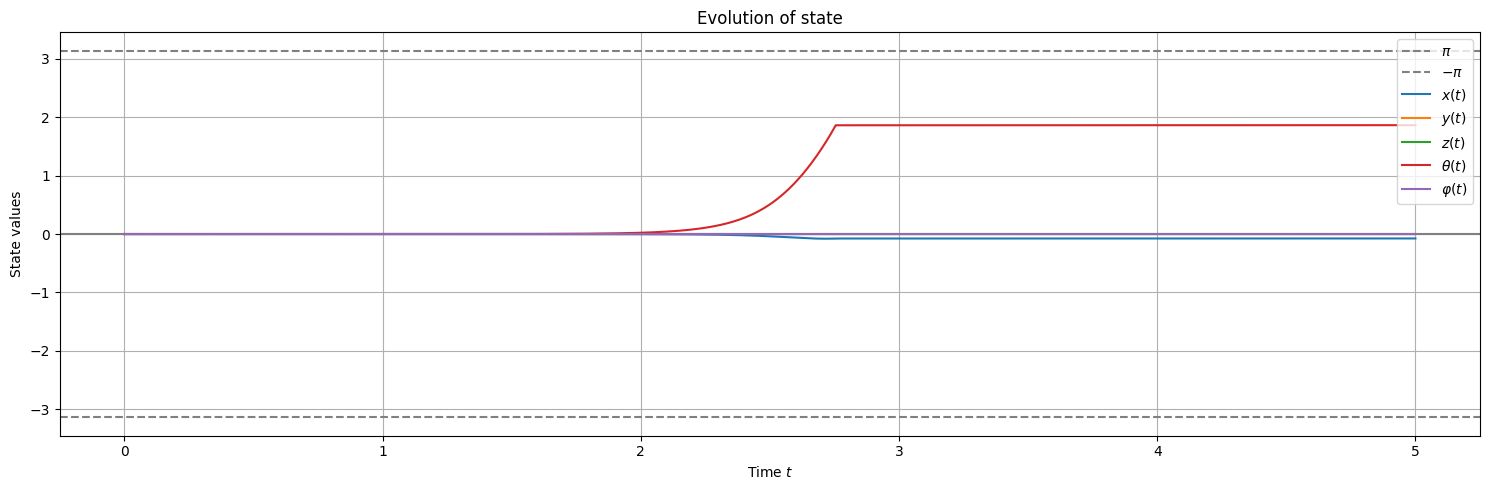

In [73]:
plt.figure(figsize=(15, 5))

plt.axhline(y=0.0, linestyle='-', color='gray')
plt.axhline(y=np.pi, linestyle='--', color='gray', label=r'$\pi$')
plt.axhline(y=-np.pi, linestyle='--', color='gray', label=r'$-\pi$')

plt.plot(sol_t, sol_x, label=r'$x(t)$')
plt.plot(sol_t, sol_y, label=r'$y(t)$')
plt.plot(sol_t, sol_z, label=r'$z(t)$')
plt.plot(sol_t, sol_theta, label=r'$\theta(t)$')
plt.plot(sol_t, sol_phi, label=r'$\varphi(t)$')

plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('Evolution of state')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

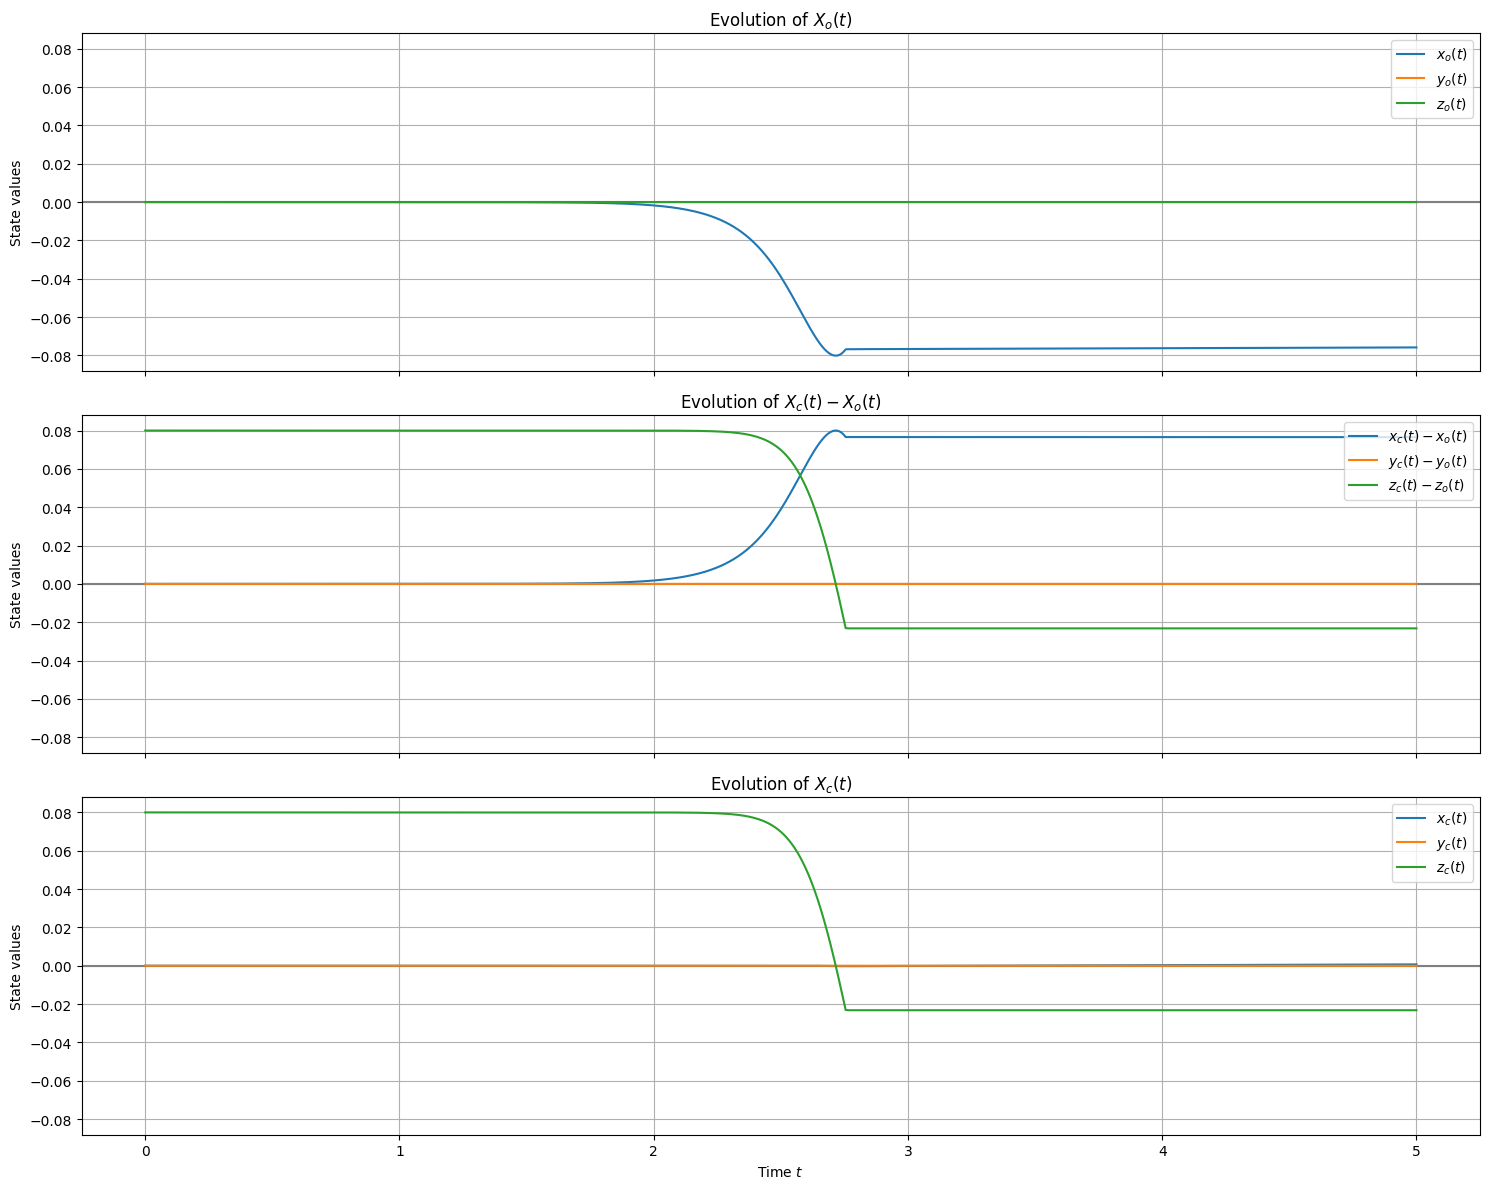

In [74]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey=True)

# Evolution of X_o
axes[0].axhline(y=0.0, linestyle='-', color='gray')
axes[0].plot(sol_t, sol_xo, label=[r'$x_o(t)$', r'$y_o(t)$', r'$z_o(t)$'])
axes[0].set_ylabel('State values')
axes[0].set_title('Evolution of $X_o(t)$')
axes[0].legend(loc='upper right')
axes[0].grid(True)

# Evolution of X_c - X_o
axes[1].axhline(y=0.0, linestyle='-', color='gray')
axes[1].plot(sol_t, sol_xc - sol_xo, label=[r'$x_c(t)-x_o(t)$', r'$y_c(t)-y_o(t)$', r'$z_c(t)-z_o(t)$'])
axes[1].set_ylabel('State values')
axes[1].set_title('Evolution of $X_c(t) - X_o(t)$')
axes[1].legend(loc='upper right')
axes[1].grid(True)

# Evolution of X_c
axes[2].axhline(y=0.0, linestyle='-', color='gray')
axes[2].plot(sol_t, sol_xc, label=[r'$x_c(t)$', r'$y_c(t)$', r'$z_c(t)$'])
axes[2].set_xlabel('Time $t$')
axes[2].set_ylabel('State values')
axes[2].set_title('Evolution of $X_c(t)$')
axes[2].legend(loc='upper right')
axes[2].grid(True)

plt.tight_layout()
plt.show()

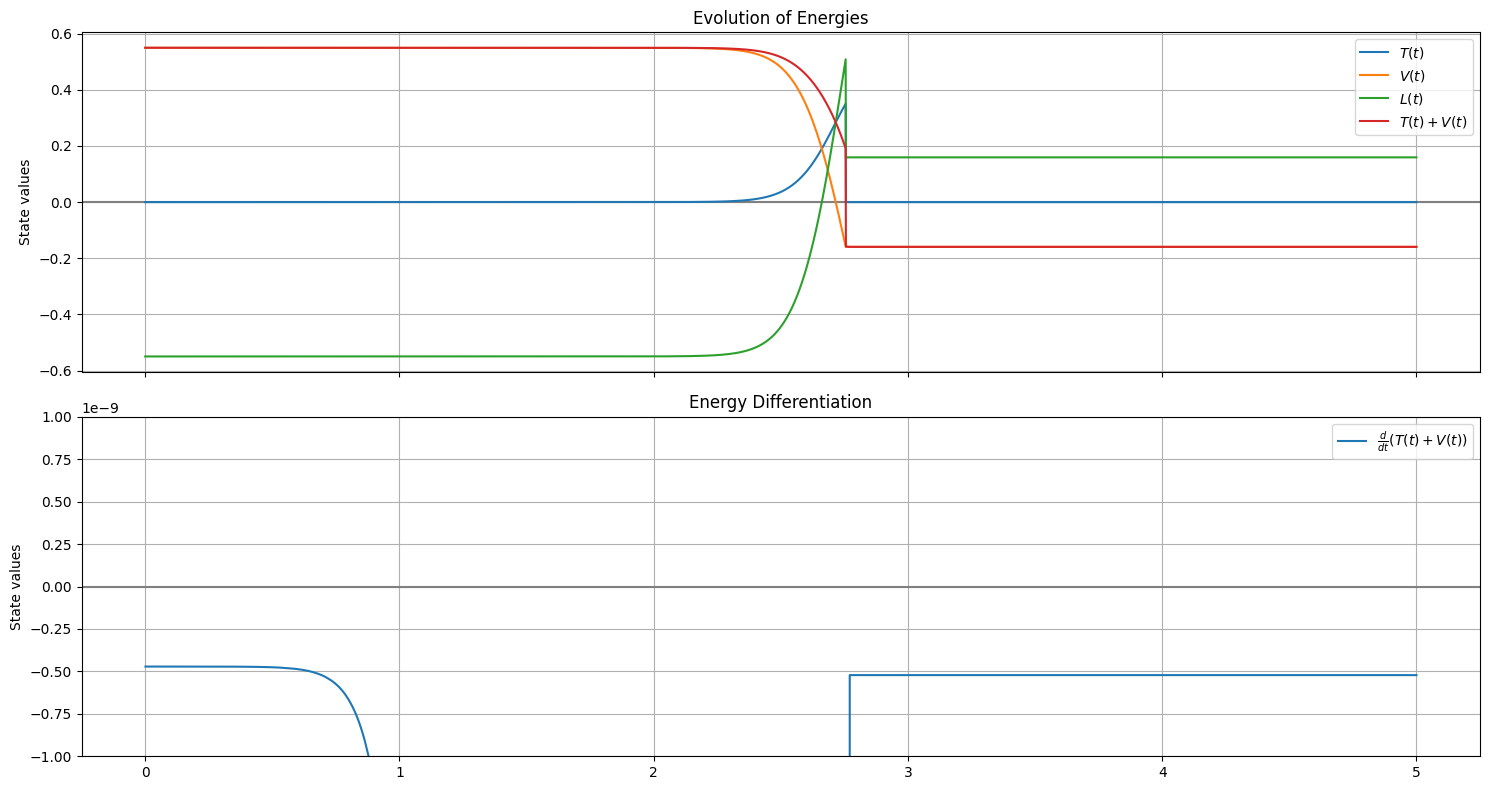

In [75]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Evolution of Energies
axes[0].axhline(y=0.0, linestyle='-', color='gray')
axes[0].plot(sol_t, sol_l_kinect, label=r'$T(t)$')
axes[0].plot(sol_t, sol_l_potential, label=r'$V(t)$')
axes[0].plot(sol_t, sol_l_lagrangian, label=r'$L(t)$')
axes[0].plot(sol_t, sol_l_mechanical, label=r'$T(t) + V(t)$')
axes[0].set_ylabel('State values')
axes[0].set_title('Evolution of Energies')
axes[0].legend(loc='upper right')
axes[0].grid(True)

# Energy Differentiation
sol_l_mechanical_diff = [(sol_l_mechanical[i] - sol_l_mechanical[i - 1]) / dt for i in range(1, len(sol_t))]
axes[1].axhline(y=0.0, linestyle='-', color='gray')
axes[1].plot(sol_t[1:], sol_l_mechanical_diff, label=r'$\frac{d}{dt}\left(T(t) + V(t)\right)$')
lres_ylim = 10.0 ** math.ceil(np.log10(np.abs(np.max(sol_l_mechanical_diff))))
axes[1].set_ylim(-lres_ylim, lres_ylim)
axes[1].set_ylabel('State values')
axes[1].set_title('Energy Differentiation')
axes[1].legend(loc='upper right')
axes[1].grid(True)

plt.tight_layout()
plt.show()